# Setup Environment

In [1]:
import os
import sys
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
def init_spark():
    return SparkSession \
        .builder \
        .master("local[4]") \
        .appName("Chess Preprocess") \
        .config("spark.executor.instances", 4) \
        .config("spark.executor.cores", 4) \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

spark = init_spark()

In [3]:
seed = 42

# Load Dataset

In [4]:
df = spark.read.csv('data/games.csv', header=True, inferSchema=True)

# Data Inspection

In [5]:
df.toPandas().head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Inspect Datatypes

In [6]:
df.dtypes

[('id', 'string'),
 ('rated', 'boolean'),
 ('created_at', 'double'),
 ('last_move_at', 'double'),
 ('turns', 'int'),
 ('victory_status', 'string'),
 ('winner', 'string'),
 ('increment_code', 'string'),
 ('white_id', 'string'),
 ('white_rating', 'int'),
 ('black_id', 'string'),
 ('black_rating', 'int'),
 ('moves', 'string'),
 ('opening_eco', 'string'),
 ('opening_name', 'string'),
 ('opening_ply', 'int')]

In [7]:
categorical = [feature for feature, dtype in df.dtypes if dtype in {'string', 'boolean'}]
numerical = [feature for feature, dtype in df.dtypes if dtype in {'double', 'int'}]

### Numerical Features

In [8]:
for col in numerical:
    unique_values = df.select(col).distinct()
    n_unique = unique_values.count()
    if n_unique < 50:
        print(f'{col:20s}:{[row[col] for row in unique_values.collect()]}')
    else:
        print(f'{col:20s}:{n_unique} unique values')

created_at          :13151 unique values
last_move_at        :13186 unique values
turns               :211 unique values
white_rating        :1516 unique values
black_rating        :1521 unique values
opening_ply         :[28, 12, 1, 13, 6, 16, 3, 20, 5, 19, 15, 9, 17, 4, 8, 7, 10, 11, 14, 2, 18, 22, 24]


- `created_at`: Timestamp in UTC
- `last_move_at`: Timestamp in UTC
- `turns`: Number of turns in the match
- `white_rating`: white player rating
- `black_rating`: black player rating
- `opening_ply`: Number of plies used to set up opening

### Categorical Features

In [9]:
for col in categorical:
    unique_values = df.select(col).distinct()
    n_unique = unique_values.count()
    if n_unique < 50:
        print(f'{col:20s}:{[row[col] for row in unique_values.collect()]}')
    else:
        print(f'{col:20s}:{n_unique} unique values')

id                  :19113 unique values
rated               :[True, False]
victory_status      :['resign', 'outoftime', 'mate', 'draw']
winner              :['white', 'black', 'draw']
increment_code      :400 unique values
white_id            :9438 unique values
black_id            :9331 unique values
moves               :18920 unique values
opening_eco         :365 unique values
opening_name        :1477 unique values


- `id`: Game ID, uniquely identifies a match record
- `rated`: If rated, the game result affects player ratings
- `victory_status`: How the game ended
- `winner`: Match winner
- `increment_code`: Game time setting
- `white_id`: white player id
- `black_id`: black player id
- `moves`: Sequence of moves recorded during the match
- `opening_eco`: ECO classification code for the chess openings moves
- `opening_name`: Name of opening moves

## Overview of the Target Columns

+------+-----+
|winner|count|
+------+-----+
| white|10001|
| black| 9107|
|  draw|  950|
+------+-----+



<AxesSubplot:xlabel='winner'>

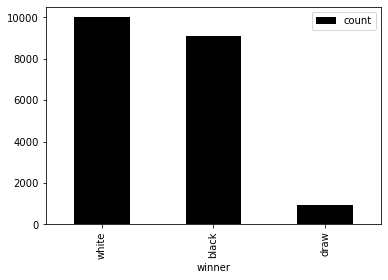

In [10]:
df.groupBy('winner').count().show()
df.groupBy('winner').count().toPandas().plot(kind='bar', x='winner', cmap='gray')

In [11]:
df.withColumn('rating_diff', df.black_rating - df.white_rating).describe('black_rating', 'white_rating', 'rating_diff').toPandas()

,summary,black_rating,white_rating,rating_diff
0,count,20058,20058,20058
1,mean,1588.8319872370128,1596.6318675840064,-7.799880346993718
2,stddev,291.0361259603342,291.25337573701825,249.03666666007965
3,min,789,784,-1499
4,max,2723,2700,1605


## Look for Anomalies

In [12]:
print( f'unique samples / total samples: {df.distinct().count()} / {df.count()} ' )

unique samples / total samples: 19629 / 20058 


In [13]:
print('Count Null Values in each Column')
df.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in df.columns]).toPandas()

Count Null Values in each Column


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- There are duplicate rows, which should be dropped from the dataset.
- Luckily, this dataset does not contain missing values.

# Data Preparation (Preprocessing)
Scikit-Learn offers a range of useful methods for preprocessing and data splits. With the approval from the course instructor, we will transform the datasets into *Pandas DataFrames* in this part.

In [14]:
# from sklearn.preprocessing import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

## Fix Anomalies

In [15]:
# Drop Duplicates
df = df.distinct()

## Label `winner`


In [16]:
label_indexer = StringIndexer(inputCol='winner', outputCol='winner_label')
label_indexer_model = label_indexer.fit(df)
df = label_indexer_model.transform(df)
df.select('winner', 'winner_label').distinct().show()
df = df.drop('winner').withColumnRenamed('winner_label', 'winner')

+------+------------+
|winner|winner_label|
+------+------------+
|  draw|         2.0|
| white|         0.0|
| black|         1.0|
+------+------------+



## Feature `increment_code`
As per inspection, the feature contains a string with two numbers separated by `+`. After research, we found that the first number refers to initial total clock time per player in *minutes*; the second number refers to the number of *seconds* added to the total clock time after the player makes a move. We decided to extract these two numbers as two separate features `clock` and `increment` replacing `increment_code`.

In [17]:
df.select('increment_code').head(3)

[Row(increment_code='30+25'),
 Row(increment_code='10+0'),
 Row(increment_code='10+3')]

In [18]:
splits = F.split(df.increment_code, '[+]')
df = df.withColumn('clock', splits.getItem(0).cast('Integer')).withColumn('increment', splits.getItem(1).cast('Integer'))
df.select('clock', 'increment').tail(3)

[Row(clock=5, increment=60),
 Row(clock=8, increment=0),
 Row(clock=3, increment=10)]

## Feature `opening_eco`
As per inspection, each row of this feature is a concatenation of a letter that denotes an [opening moves category](https://www.365chess.com/eco.php). Although there are variations within each category, we assume that the opening moves in each category to be similar enough that we can ignore the differences within each opening move category. Therefore, we extract the first letter from `opening_eco` to a new feature `open_cat` and ignore `opening_eco` during training.

In [19]:
df.select('opening_eco').show(3)

+-----------+
|opening_eco|
+-----------+
|        B11|
|        B45|
|        C60|
+-----------+
only showing top 3 rows



In [20]:
df = df.withColumn('open_category', df.opening_eco.substr(0, 1))
df.select('open_category').distinct().show()

+-------------+
|open_category|
+-------------+
|            E|
|            B|
|            D|
|            C|
|            A|
+-------------+



In [21]:
open_cat_indexer = StringIndexer(inputCol='open_category', outputCol='open_cat')
open_cat_model = open_cat_indexer.fit(df)
df = open_cat_model.transform(df)
df.select('open_category', 'open_cat').distinct().show()

+-------------+--------+
|open_category|open_cat|
+-------------+--------+
|            D|     3.0|
|            B|     1.0|
|            E|     4.0|
|            C|     0.0|
|            A|     2.0|
+-------------+--------+



## Feature `rated`
Contains boolean values only and does not require preprocessing. Rated games affect player ratings and may affect performance of the player. We may choose to separate rated games from unrated games for this fact, here we did not.

## Split into Train/Test Sets
1. Encode player ids into numerical values.
    - Ensure that each player is assigned one and only one numerical id.
2. Use encoded player ids to split dataset based on groups.
    - Each group contains the matches played by one player. Make sure that each group are sampled evenly in the training set.

In [22]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

### Transform Spark DF to __Pandas DF__
Scikit-Learn Split methods cannot handle distributed datasets. Because we want to leverage the `GroupSplit` method in Scikit-Learn, we are turning the Spark DF into Pandas DF.

In [23]:
df_pd = df.toPandas()

### Encode categorical player `white_id`s `black_id`s to split based on individual players

In [24]:
player_ids = pd.DataFrame(df_pd[['white_id', 'black_id']])
player_ids = player_ids.stack().pipe(lambda s: pd.Series(pd.factorize(s.values)[0], s.index)).unstack()

df_pd['white_idx'] = player_ids['white_id']
df_pd['black_idx'] = player_ids['black_id']

df_pd[['white_id', 'white_idx', 'black_id', 'black_idx']]

,white_id,white_idx,black_id,black_idx
0,konst767,0,ducksandcats,1
1,everybodylovesjesus,2,ahmd11,3
2,jeff1983,4,bekzodjon,5
3,mellowg7,6,jesteroz,7
4,omnivoid,8,hasan_al-banna,9
...,...,...,...,...
19624,demontechristo66,9815,eie24,3698
19625,r-mohamadi55,15633,eie24,3698
19626,kastorcito,5322,ed84,4132
19627,ssf7,3469,casr,15634


### Data Split

In [25]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_idx, test_idx = next(gss.split(df_pd, df_pd['winner'], groups=df_pd['white_idx']))

df_train = df_pd.iloc[train_idx]

df_test = df_pd.iloc[test_idx]

In [26]:
# Proof that none of the IDs from the training set are present in the test set.
df_train_values = set(df_train['white_id'].values)
df_test_values = set(df_test['white_id'].values)

assert len(df_train_values.intersection(df_test_values)) == 0, 'A group is present in both training and test sets'

### Transform Pandas DF Train/Test Set to __Spark DF__

In [27]:
df_train = spark.createDataFrame(df_train)

df_test = spark.createDataFrame(df_test)

## Feature `victory_status`
From inspection, we observe 4 unique values for this categorical feature: `'resign', 'outoftime', 'mate', 'draw'`. We perform one-hot encoding before feeding this into the model. For Spark, the result is a `DenseVector` that can be fed into the Spark ML models. 

In [29]:
si = StringIndexer(inputCol="victory_status", outputCol="victory_status_code")
ohe = OneHotEncoder(inputCol=si.getOutputCol(), outputCol="match_status", handleInvalid='keep')
statusEncoderPipeline = Pipeline(stages=[si, ohe])
statusEncoderModel = statusEncoderPipeline.fit(df_train)

In [30]:
df_train = statusEncoderModel.transform(df_train)
df_test = statusEncoderModel.transform(df_test)

In [31]:
df_train.select('victory_status', 'victory_status_code', 'match_status').head()

Row(victory_status='resign', victory_status_code=0.0, match_status=SparseVector(4, {0: 1.0}))

## Feature `moves`
As per inspection, this feature records the list/sequence of moves during the match. Because that the sequence, if parsed correctly, actually indicates the winning player, we need to either drop this feature or obfuscate this information. We find that Spark supports Word2Vec feature transformation, which will turn the sequence into a vector. Such vector representation is independent of the order of the moves, and this can obfuscate part of the information lied within this feature.

In [32]:
from pyspark.ml.feature import Word2Vec

In [33]:
df_train.select('moves').head().moves

'e4 c6 Nc3 d5 Nf3 Bg4 h3 Bh5 exd5 cxd5 Bb5+ Nc6 g4 Bg6 Ne5 Qb6 Nxg6 hxg6 Nxd5 Qc5 Qf3 Rc8 Nc3 e6 d3 Qe5+ Qe4 Bd6 Be3 Ne7 Bd4 Qxe4+ Nxe4 Bb8 Bxg7 Rh4 Bf6 Rh6'

In [34]:
vectorSize = 100
word2Vec = Word2Vec(vectorSize=vectorSize, seed=seed, inputCol="moves_list", outputCol="moves_vec")

Parameters for `Word2Vec`
- `vectorSize`: size of the output vector, the choice of 100 is arbitrary here
- `minCount`: Ignores all words with total frequency lower than this.
- `inputCol`: `moves_list` is the input feature, a list of `moves` split by space
- `outputCol`: `moves_vec` is the output feature, the transformed vector

The Word2Vec model will be trained with the corpus gathered from the `moves` in the training set. After which, it will transform both training and testing datasets' `moves` feature.

In [35]:
# split moves from string into list of strings, moves -> [move, move, ...]
train_moves_corpus = df_train.select(F.split(df_train.moves, '\s', -1).alias('moves_list'))
train_moves_corpus

DataFrame[moves_list: array<string>]

In [36]:
fitted_word2Vec = word2Vec.fit(train_moves_corpus)
print('Trained Word2Vec Model')
fitted_word2Vec.getVectors().show(5)

Trained Word2Vec Model
+-----+--------------------+
| word|              vector|
+-----+--------------------+
| Bxd2|[0.08646679669618...|
| Nxf6|[-0.3127570748329...|
|  a2+|[0.02550127729773...|
|Bxd5+|[0.14410454034805...|
|  Kg8|[-0.1851859688758...|
+-----+--------------------+
only showing top 5 rows



C:\tools\miniconda3\envs\bigdata\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [37]:
'Transformed Moves for the 1st Match in Training Set: ', fitted_word2Vec.transform(train_moves_corpus).head().moves_vec

('Transformed Moves for the 1st Match in Training Set: ',
 DenseVector([0.1149, 0.0761, 0.019, 0.0671, -0.1265, -0.0495, -0.0001, 0.0269, -0.0027, 0.0543, -0.0921, -0.043, 0.0581, 0.0162, -0.0572, -0.0128, 0.0236, -0.0254, 0.0416, 0.104, -0.0107, -0.0327, -0.0123, -0.0158, -0.0854, -0.0706, -0.1003, -0.0493, 0.0998, -0.0557, 0.025, 0.0252, 0.0767, -0.0238, 0.1444, 0.1162, -0.0034, 0.0435, -0.0162, -0.1023, -0.0363, 0.0349, -0.0397, -0.0861, -0.1683, -0.1017, -0.0548, 0.0306, -0.0268, 0.0998, -0.0735, 0.0093, 0.0021, -0.0197, -0.0052, 0.0371, 0.033, 0.0168, -0.0196, 0.0726, -0.0009, 0.0104, -0.0574, 0.0021, -0.0818, -0.0809, 0.0882, 0.0114, -0.0434, -0.0145, 0.0182, -0.0209, -0.0122, 0.1118, 0.0584, -0.0295, -0.0278, -0.0114, 0.115, 0.1062, -0.0852, -0.0015, 0.0958, 0.0385, -0.0011, 0.0064, 0.0006, -0.0648, 0.0568, -0.0183, -0.0443, -0.1293, 0.0597, 0.0492, -0.0374, -0.133, 0.0243, -0.056, 0.0682, 0.0676]))

In [38]:
df_train = df_train.withColumn('moves_list', F.split(df_train.moves, '\s', -1))
df_train = fitted_word2Vec.transform(df_train)

df_test = df_test.withColumn('moves_list', F.split(df_test.moves, '\s', -1))
df_test = fitted_word2Vec.transform(df_test)

# Save Datasets

In [39]:
df_train.toPandas().to_csv('data/train.csv', index=False)
df_test.toPandas().to_csv('data/test.csv', index=False)

# Classification Problem
 In a new match between two players, who is most likely to win?

## Feature Selection

In [40]:
features = 'rated', 'turns', 'match_status', 'clock', 'increment', 'white_rating', 'black_rating', 'open_cat', 'opening_ply', 'moves_vec'
target = 'winner'
inputColumns = features + (target,)
inputColumns

('rated',
 'turns',
 'match_status',
 'clock',
 'increment',
 'white_rating',
 'black_rating',
 'open_cat',
 'opening_ply',
 'moves_vec',
 'winner')

In [41]:
training_assembler = VectorAssembler(handleInvalid='error', inputCols=features, outputCol='features')
test_assembler = VectorAssembler(handleInvalid='error', inputCols=features, outputCol='features')

In [42]:
clf_train_df = training_assembler.transform(df_train.select(*inputColumns)).select('features', target)
clf_test_df = test_assembler.transform(df_test.select(*inputColumns)).select('features', target)

## Model Selection

In [43]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### *Decision Tree* for Classification

In [44]:
dt = DecisionTreeClassifier(labelCol=target, featuresCol="features", seed=seed)

dtParamGrid = (ParamGridBuilder()
               .addGrid(dt.maxDepth, list(range(2, 8)))
               .addGrid(dt.maxBins, [4, 8, 16, 32, 64])
               .addGrid(dt.minInstancesPerNode, list(range(1, 4)))
               .addGrid(dt.impurity, ['gini', 'entropy'])
               .build())

dtEvaluator = MulticlassClassificationEvaluator(labelCol=target, metricName='f1')

From [Spark Docs](https://spark.apache.org/docs/latest/mllib-decision-tree.html#tunable-parameters)
- `maxDepth`: Maximum depth of a tree. Deeper trees are more expressive (potentially allowing higher accuracy), but they are also more costly to train and are more likely to overfit.
- `minInstancesPerNode`: For a node to be split further, each of its children must receive at least this number of training instances. This is commonly used with RandomForest since those are often trained deeper than individual trees.
- `maxBins`: Number of bins used when discretizing continuous features.
- `impurity`: Measure of the homogeneity of the labels at the node. (Choice of `gini` and `entropy` for classification)

#### Hyperparameter Tuning (Grid Search)  20-30 minutes

In [44]:
dtCv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtParamGrid,
                      evaluator = dtEvaluator,
                      numFolds = 5)

dtCvModel = dtCv.fit(clf_train_df)

bestParamMap = dtCvModel.bestModel.extractParamMap()

In [45]:
# Best Parameters found
print( ','.join([''.join((param.name, '=', repr(value))) for param, value in bestParamMap.items()]) )

cacheNodeIds=False,checkpointInterval=10,featuresCol='features',impurity='gini',labelCol='winner',leafCol='',maxBins=8,maxDepth=6,maxMemoryInMB=256,minInfoGain=0.0,minInstancesPerNode=1,minWeightFractionPerNode=0.0,predictionCol='prediction',probabilityCol='probability',rawPredictionCol='rawPrediction',seed=42


#### Model Train

In [45]:
# Use Best Parameters to initialize and train a separate classifier model
dtBest = DecisionTreeClassifier(cacheNodeIds=False,checkpointInterval=10,featuresCol='features',impurity='gini',labelCol='winner',leafCol='',maxBins=8,maxDepth=6,maxMemoryInMB=256,minInfoGain=0.0,minInstancesPerNode=1,minWeightFractionPerNode=0.0,predictionCol='prediction',probabilityCol='probability',rawPredictionCol='rawPrediction',seed=42)
# assert dtBest.extractParamMap() == bestParamMap, 'Check if the input parameters are the best found. '
bestModel = dtBest.fit(clf_train_df)

#### Model Evaluation

In [46]:
print('train f1 score', dtEvaluator.evaluate(bestModel.transform(clf_train_df)))
print('test f1 score', dtEvaluator.evaluate(bestModel.transform(clf_test_df)))

train f1 score 0.706133786987661
test f1 score 0.6720110224218644


Because the classes are imbalanced and that we don't favor one class over the other, we adopted the F1 score as the main metric to evaluate our model. Given that there are 3 output classes, this result is acceptable for a simple decision tree classifier. For better performance, we could use Ensembling methods such as Random Forest. 

### *Logistic Regression*

In [47]:
lr = LogisticRegression(labelCol=target, featuresCol="features")

lrParamGrid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.01, 0.1, 0.2, 0.8, 2.0])
               .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4])
               .addGrid(lr.fitIntercept, [True, False])
               .addGrid(lr.maxIter, [10, 30, 50, 70, 100])
               .build())

lrEvaluator = MulticlassClassificationEvaluator(labelCol=target, metricName='f1')

From [Medium Article by Dhiraj Rai](https://dhiraj-p-rai.medium.com/logistic-regression-in-spark-ml-8a95b5f5434c)
- `regParam` the regularization parameter (>= 0). (default: 0.0)
- `elasticNetParam` the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
- `fitIntercept` whether to fit an intercept term. (default: True)
- `maxIter` maximum iteration number.
- `standardization` whether to standardize the training features before fitting the model. The coefficients of models will always be returned on the original scale, so it will be transparent for users. (default: True)

#### Hyperparameter Tuning (Grid Search) ~50 minutes

In [49]:
lrCv = CrossValidator(estimator = lr,
                      estimatorParamMaps = lrParamGrid,
                      evaluator = lrEvaluator,
                      numFolds = 5)

lrCvModel = lrCv.fit(clf_train_df)

bestParamMap = lrCvModel.bestModel.extractParamMap()

In [50]:
# Best Parameters found
print( ','.join([''.join((param.name, '=', repr(value))) for param, value in bestParamMap.items()]) )

aggregationDepth=2,elasticNetParam=0.2,family='auto',featuresCol='features',fitIntercept=False,labelCol='winner',maxBlockSizeInMB=0.0,maxIter=100,predictionCol='prediction',probabilityCol='probability',rawPredictionCol='rawPrediction',regParam=0.01,standardization=True,threshold=0.5,tol=1e-06


#### Model Train

In [48]:
lrBest = LogisticRegression(aggregationDepth=2,elasticNetParam=0.2,family='auto',featuresCol='features',fitIntercept=False,labelCol='winner',maxBlockSizeInMB=0.0,maxIter=100,predictionCol='prediction',probabilityCol='probability',rawPredictionCol='rawPrediction',regParam=0.01,standardization=True,threshold=0.5,tol=1e-06)
# assert lrBest.extractParamMap() == bestParamMap, 'Check if the input parameters are the best found. '
bestModel = lrBest.fit(clf_train_df)

#### Model Evaluation

In [49]:
print('train f1 score', lrEvaluator.evaluate(bestModel.transform(clf_train_df)))
print('test f1 score', lrEvaluator.evaluate(bestModel.transform(clf_test_df)))

train f1 score 0.7636212881018776
test f1 score 0.7470659930946674


The LogisticRegression performs significantly better than the DecisionTreeRegressor. 

# Regression Problem
 Can a player's rating be determined from a single match record with another player?

## Feature Selection

In [50]:
features = 'rated', 'turns', 'match_status', 'clock', 'increment', 'open_cat', 'opening_ply', 'moves_vec', 'winner', #'white_rating',
target = 'black_rating'
inputColumns = features + (target,)
inputColumns

('rated',
 'turns',
 'match_status',
 'clock',
 'increment',
 'open_cat',
 'opening_ply',
 'moves_vec',
 'winner',
 'black_rating')

In [51]:
training_assembler = VectorAssembler(handleInvalid='error', inputCols=features, outputCol='features')
test_assembler = VectorAssembler(handleInvalid='error', inputCols=features, outputCol='features')

In [52]:
reg_train_df = training_assembler.transform(df_train.select(*inputColumns)).select('features', target)
reg_test_df = test_assembler.transform(df_test.select(*inputColumns)).select('features', target)

## Model Selection

In [53]:
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

### *Decision Tree* for Regression

In [54]:
dt = DecisionTreeRegressor(labelCol=target, featuresCol="features", seed=seed)

dtParamGrid = (ParamGridBuilder()
               .addGrid(dt.maxDepth, list(range(2, 8)))
               .addGrid(dt.maxBins, [4, 8, 16, 32, 64])
               .addGrid(dt.minInstancesPerNode, list(range(1, 4)))
               .build())

dtEvaluator = RegressionEvaluator(labelCol=target, metricName='rmse')

From [Spark Docs](https://spark.apache.org/docs/latest/mllib-decision-tree.html#tunable-parameters)
- `maxDepth`: Maximum depth of a tree. Deeper trees are more expressive (potentially allowing higher accuracy), but they are also more costly to train and are more likely to overfit.
- `minInstancesPerNode`: For a node to be split further, each of its children must receive at least this number of training instances. This is commonly used with RandomForest since those are often trained deeper than individual trees.
- `maxBins`: Number of bins used when discretizing continuous features.
- `impurity`: Impurity measure used to choose between candidate splits. (Only `variance` for regression)

#### Hyperparameter Tuning (Grid Search) ~18 min

In [ ]:
dtCv = CrossValidator(estimator = dt,
                      estimatorParamMaps = dtParamGrid,
                      evaluator = dtEvaluator,
                      numFolds = 5)

dtCvModel = dtCv.fit(reg_train_df)

bestParamMap = dtCvModel.bestModel.extractParamMap()

In [ ]:
# Best Parameters found
print( ','.join([''.join((param.name, '=', repr(value))) for param, value in bestParamMap.items()]) )

#### Model Train

In [55]:
# Use Best Parameters to initialize and train a separate classifier model
dtBest = DecisionTreeRegressor(cacheNodeIds=False,checkpointInterval=10,featuresCol='features',impurity='variance',labelCol='black_rating',leafCol='',maxBins=8,maxDepth=6,maxMemoryInMB=256,minInfoGain=0.0,minInstancesPerNode=3,minWeightFractionPerNode=0.0,predictionCol='prediction',seed=42) 
# assert dtBest.extractParamMap() == bestParamMap, 'Check if the input parameters are the best found. '
bestModel = dtBest.fit(reg_train_df)

#### Model Evaluation

In [56]:
print('train rmse', dtEvaluator.evaluate(bestModel.transform(reg_train_df)))
print('test rmse', dtEvaluator.evaluate(bestModel.transform(reg_test_df)))

train rmse 259.3537297282463
test rmse 275.8599898782995


The RMSE score is very close to the standard deviation of the difference between `black_rating` and `white_rating`. If the model is given the `white_rating` feature, the RMSE would see a decrease of about 40, further improving the model prediction.

### *Linear Regression*

In [57]:
lr = LinearRegression(labelCol=target, featuresCol="features")

lrParamGrid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.01, 0.1, 0.2, 0.8, 2.0])
               .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4])
               .addGrid(lr.fitIntercept, [True, False])
               .addGrid(lr.maxIter, [10, 30, 50, 70, 100])
               .addGrid(lr.solver, ['auto', 'normal', 'l-bfgs'])
               .build())

lrEvaluator = RegressionEvaluator(labelCol=target, metricName='rmse')

From [Medium Article by Dhiraj Rai](https://dhiraj-p-rai.medium.com/logistic-regression-in-spark-ml-8a95b5f5434c)
- `regParam` the regularization parameter (>= 0). (default: 0.0)
- `elasticNetParam` the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
- `fitIntercept` whether to fit an intercept term. (default: True)
- `maxIter` maximum iteration number.
- `standardization` whether to standardize the training features before fitting the model. The coefficients of models will always be returned on the original scale, so it will be transparent for users. (default: True)

#### Hyperparameter Tuning (Grid Search)

In [74]:
lrCv = CrossValidator(estimator = lr,
                      estimatorParamMaps = lrParamGrid,
                      evaluator = lrEvaluator,
                      numFolds = 5)

lrCvModel = lrCv.fit(reg_train_df)

bestParamMap = lrCvModel.bestModel.extractParamMap()

In [75]:
# Best Parameters found
print( ','.join([''.join((param.name, '=', repr(value))) for param, value in bestParamMap.items()]) )

aggregationDepth=2,elasticNetParam=0.0,epsilon=1.35,featuresCol='features',fitIntercept=True,labelCol='black_rating',loss='squaredError',maxBlockSizeInMB=0.0,maxIter=30,predictionCol='prediction',regParam=0.1,solver='auto',standardization=True,tol=1e-06


#### Model Train

In [58]:
lrBest = LinearRegression(aggregationDepth=2,elasticNetParam=0.0,epsilon=1.35,featuresCol='features',fitIntercept=True,labelCol='black_rating',loss='squaredError',maxBlockSizeInMB=0.0,maxIter=30,predictionCol='prediction',regParam=0.1,solver='auto',standardization=True,tol=1e-06)   
# assert lrBest.extractParamMap() == bestParamMap, 'Check if the input parameters are the best found. '
bestModel = lrBest.fit(reg_train_df)

#### Model Evaluation

In [59]:
print( 'train rmse score', lrEvaluator.evaluate(bestModel.transform(reg_train_df)) )
print( 'test rmse score', lrEvaluator.evaluate(bestModel.transform(reg_test_df)) )

train rmse score 250.66053890029065
test rmse score 258.24699917173814


Similarly to DecisionTreeRegressor, the RMSE score is very close to the standard deviation of the difference between `black_rating` and `white_rating`. It performs slightly better. If the model is given the `white_rating` feature, the RMSE would see a decrease of about 40, further improving the model prediction.